# Convolutional Neural Network: Stop Sign Identifier

### Classifying Stop Signs Against Yield Signs

The goal of this model is to classify stop signs from yield signs. This will be built with a convolutional neural network using binary categories. The end goal is to use this model to develop an R-CNN to determine whether a given image has a stop sign in it.
<br>
<br>
First, we will import to relevant modules.

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from skimage.util import random_noise
from skimage.transform import rotate, AffineTransform, warp

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn
import pickle
import random

#### Image Data Collection

Image for training and validation data will be **grayscale** with dimensions of **64x64** pixels. The *get_image* function will retrive image data and reformat them to meet those attributes.
<br>
<br>
Each image will be assigned a label of **1** or **0**, for stop signs and yield signs respectively. We will now define our function and collect the data.

In [10]:
img_size = 64

def get_image(path):
    bgr_arr = cv2.imread(path)
    resize_arr = cv2.resize(bgr_arr, (img_size, img_size))
    grayscale_arr = cv2.cvtColor(resize_arr, cv2.COLOR_BGR2GRAY)
    return random_noise(grayscale_arr)

In [11]:
stop_images = [(get_image('cnn/stop_signs/' + img), 1) for img in os.listdir('cnn/stop_signs')]
yield_images = [(get_image('cnn/yield_signs/' + img), 0) for img in os.listdir('cnn/yield_signs')]

Now that we have two arrays, one for each classification, we can merge the data into one full array. After the merge, we will shuffle the list to create a degree of randomness with our images

In [12]:
full_data = stop_images + yield_images

random.seed(25)
random.shuffle(full_data)

#### Image Augmentation

Now that all of our image data has been collected, combined, and shuffled, we can augment our data to drastically expand the number of data that we have. This way, we will be able to train a robust model despite our limited collection of images.
<br>
<br>
First, we will define our *augment* function. This function utilizes a heavy degree of randomness so it can be used several times in succession with different results. The steps for augmenting a given image once:
1. Flip the image vertically if it succeeds on a coin flip's chance (50%)
2. Flip the image horizontally if it succeeds on a coin flip's chance (50%)
3. Rotate the image randomly on a certain number of degrees from intervals of 45&deg;

<br>
Next, we will append some augmented images to our data set. For each image, we will add 8 augmentations of that image to the data. This will grow the number of points in our set to an appropriate number for the model we are going to build.

In [13]:
def augment(img):
    new_img = img
    if random.choice([True, False]):
        new_img = np.fliplr(new_img)
    if random.choice([True, False]):
        new_img = np.flipud(new_img)
            
    return rotate(new_img, angle=random.randrange(0, 360, 45))

In [14]:
data_length = len(full_data)
for i in range(data_length):
    img, label = full_data[i]
    for n in range(8):
        full_data.append((augment(img), label))

#### Data Preparation

After collecting and expanding our data, we can now split it into training and validation data. Our training data will consist of 75% of the full dataset. We will also normalize our data to better prepare it for the neural network. Since each pixel value in a given image ranges from 0 to 255, we will divide our image data by 255.

In [15]:
train_size = int(len(full_data) * 0.75)

X_train = np.array([element[0] for element in full_data[:train_size]]) / 255
y_train = np.array([element[1] for element in full_data[:train_size]])

X_test = np.array([element[0] for element in full_data[train_size:]]) / 255
y_test = np.array([element[1] for element in full_data[train_size:]])

In [16]:
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)

#### Early Visualizations

Now that our data has been fully prepared, we can plot some early visualizations for our data.

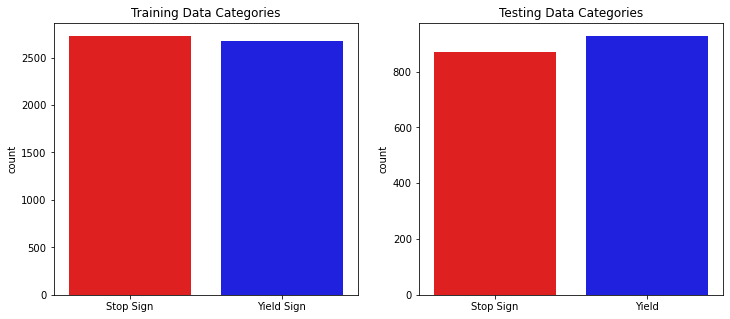

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ax = seaborn.countplot(x=y_train, order=[1, 0], palette=['red', 'blue'])
ax.set_xticklabels(['Stop Sign', 'Yield Sign'])
ax.set_title('Training Data Categories')

plt.subplot(1, 2, 2)
ax2 = seaborn.countplot(x=y_test, order=[1, 0], palette=['red', 'blue'])
ax2.set_xticklabels(['Stop Sign', 'Yield'])
ax2.set_title('Testing Data Categories')

plt.show()

#### Building the Model

We can now begin building our model. This **sequential convolutional neural network** consists of several layers:
- **Convolutional (Conv2D) Layer**: extracts features of an image by sliding a kernal matrix over the pixels
- **Max Pooling (MaxPool2d) Layer**: reduces image size by combining pixels into a single value using their maximum
- **Flatten Layer**: flattens the image into a one dimensional array of pixel values for the fully connected layers
- **Dense Layer**: fully connected neural network layer
- **Dropout Layer**: reduces overfitting by randomly dropping fully connected nodes


We will use the *ReLU* activation function for each layer, and the *sigmoid* function for our final output layer because we only have two categories. In addition, we will use "same" padding for our convolutional layer (padding used to maintain image size) and "valid" padding for our max pool layer (no padding, so image size is reduced).
<br>
<br>
In order to prevent overfitting, the most common problem in convolutional neural networks, we will use several tactics. The most important is adding **Dropout** layers within our fully connected layer. This randomly drops several nodes, and it is highly effective in stopping the network from hyper-focusing on irrelevant features in the images and thus prevents overfitting. Along with our dropout layers, we will use L2 regularization in our fully connected nodes. This helps the model generalize to the validation data by penalizing incorrect classifications.

###### Model Structure

After several attempts at training the model, the below strcutrue was determined to be the best for hgih accuracy, low loss, and minimal overfitting. 
<br>
<br>
It consists of 3 convolutional layers of 64 nodes, 64 nodes, and 128 nodes, with a kernal size of 3. It then consists of 2 fully connected layers of 64 nodes and 128 nodes, and an output layer using the sigmoid function. In between the fully connected layers, there are dropout layers of rate 0.65.

In [18]:
model = Sequential()
model.add(Conv2D(64, 3, padding="same", activation="relu", input_shape=(img_size, img_size, 1)))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64, activation="relu", bias_regularizer=l2(0.01), activity_regularizer=l2(0.01)))
model.add(Dropout(0.65))
model.add(Dense(128, activation="relu", bias_regularizer=l2(0.01), activity_regularizer=l2(0.01)))
model.add(Dropout(0.65))
model.add(Dense(2, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

For model training, we will use a learning rate of 0.00005. Several attempts at model training determined that this would be the idea learning rate for fast learning and accurate results. We will also use **Sparse Categorical Cross Entropy** to measure loss.

In [19]:
model.compile(optimizer=Adam(learning_rate=0.00005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Training the Model

Now that the model structure has been established, we can begin what all of this has led to: *training the model*
<br>
<br>
We will use 150 epochs through our data to fully train our network. This means that our model will iterate through the all images and adjust its weights accordingly 150 times. We will record our training loss, training accuracy, validation loss, and validation accuracy at each epoch. The goal is to decrease loss and increase accuracy at each epoch.

##### Callbacks

We will utlize several callbacks in our model training in order to maximize how effictive the training process is. The first callback is *ReduceLROnPlateau*, which under our configuration will cut the learning rate in half if validation loss does not decrease by at least 0.0002 through 5 consecutive epochs. The second callback is *EarlyStopping*, which under our configuration will end the training entirely if validation loss does not decrease by at least 0.002 through 15 consecutive epochs.
<br>
<br>
These callbacks will help our training be as efficient as possible. *ReduceLROnPlateau* will help our model learn when it has gotten to a point where our learning rate is too high to continue. *EarlyStopping* will end our training once there is truly no more learning to be done, but there are still many more epochs that will do nothing but hurt the model.
<br>
Both of these callbacks have been set to print a message whenever they are used.

##### Training Run

Now, let's train our model!

In [20]:
callback_list = [ReduceLROnPlateau(min_delta=0.0002, patience=5, factor=0.5, min_lr=0.000001, verbose=1),
                EarlyStopping(min_delta=0.0002, patience=15, verbose=1)]

history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), 
                    shuffle=True, callbacks=callback_list)

Epoch 1/150
169/169 [==============================] - 19s 111ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6933 - val_accuracy: 0.4844
Epoch 2/150
169/169 [==============================] - 19s 112ms/step - loss: 0.6930 - accuracy: 0.5085 - val_loss: 0.6933 - val_accuracy: 0.4844
Epoch 3/150
169/169 [==============================] - 19s 113ms/step - loss: 0.6930 - accuracy: 0.5107 - val_loss: 0.6926 - val_accuracy: 0.4844
Epoch 4/150
169/169 [==============================] - 19s 115ms/step - loss: 0.6907 - accuracy: 0.5619 - val_loss: 0.6875 - val_accuracy: 0.6061
Epoch 5/150
169/169 [==============================] - 19s 112ms/step - loss: 0.6794 - accuracy: 0.5917 - val_loss: 0.6637 - val_accuracy: 0.5889
Epoch 6/150
169/169 [==============================] - 19s 113ms/step - loss: 0.6455 - accuracy: 0.6539 - val_loss: 0.6232 - val_accuracy: 0.6844
Epoch 7/150
169/169 [==============================] - 19s 112ms/step - loss: 0.6175 - accuracy: 0.6926 - val_loss: 0.5842 -

Epoch 57/150
169/169 [==============================] - 19s 112ms/step - loss: 0.2175 - accuracy: 0.9287 - val_loss: 0.3012 - val_accuracy: 0.8950
Epoch 58/150
169/169 [==============================] - 19s 112ms/step - loss: 0.2152 - accuracy: 0.9298 - val_loss: 0.3016 - val_accuracy: 0.8944
Epoch 59/150
169/169 [==============================] - 19s 111ms/step - loss: 0.2198 - accuracy: 0.9280 - val_loss: 0.2861 - val_accuracy: 0.8928
Epoch 60/150
169/169 [==============================] - 19s 111ms/step - loss: 0.2099 - accuracy: 0.9328 - val_loss: 0.2686 - val_accuracy: 0.8911
Epoch 61/150
169/169 [==============================] - 19s 111ms/step - loss: 0.2019 - accuracy: 0.9365 - val_loss: 0.2870 - val_accuracy: 0.9011
Epoch 62/150
169/169 [==============================] - 19s 114ms/step - loss: 0.1971 - accuracy: 0.9396 - val_loss: 0.2625 - val_accuracy: 0.8889
Epoch 63/150
169/169 [==============================] - 19s 114ms/step - loss: 0.1955 - accuracy: 0.9365 - val_loss: 0

Fantastic! Our model has a validation loss of just 0.1894 and a validation accuracy of almost **94%!** 
<br>
This is a really robust model that will effectively distinguish stop signs from yield signs in almost all cases!

#### Final Visualizations

Now that our model has been trained and has a high accuracy, it's time for a few final visualizations to further understand what our model achieved.

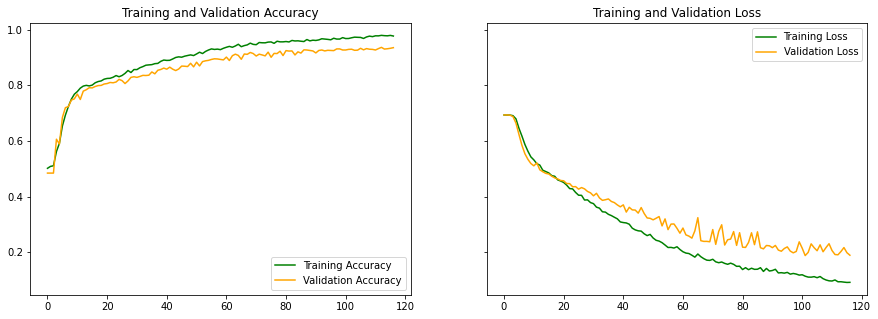

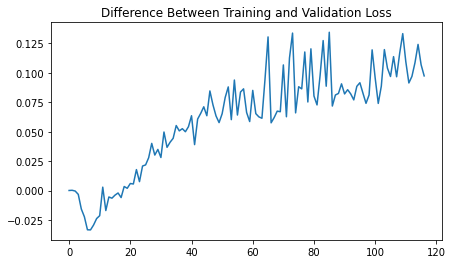

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=((15, 5)))
ax1.plot(history.epoch, acc, label='Training Accuracy', color='green')
ax1.plot(history.epoch, val_acc, label='Validation Accuracy', color='orange')
ax1.legend(loc='lower right')
ax1.set_title('Training and Validation Accuracy')

ax2.plot(history.epoch, loss, label='Training Loss', color='green')
ax2.plot(history.epoch, val_loss, label='Validation Loss', color='orange')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(history.epoch, np.array(val_loss) - np.array(loss))
plt.title('Difference Between Training and Validation Loss')
plt.show()